# Steam Game Price Prediction

# Abstract 
This study aims to predict the discount prices of games on Steam, along with the rich metadata and user-generated tags associated with each game. The dataset comprises 71,700 entries, game titles, original and discounted prices, release dates, developer and publisher information, supported languages, popular user tags, game features, and minimum requirements. These entries are primarily textual and categorical, with numerical representations for prices. Our methodology involves preprocessing the data, including handling missing values and transforming user-generated tags into one-hot encoded vectors to quantify the categorical data effectively. We will explore the dataset through exploratory data analysis (EDA) to uncover underlying patterns and relationships. The study will then apply clustering techniques, specifically DBSCAN, Spectral Clustering, and Gaussian Mixture Models (GMM), to group games based on their tags and features. This clustering will serve as a foundation for predicting game discount prices. The performance of our price prediction model will be evaluated using the Mean Absolute Error (MAE), while the effectiveness of our clustering approach will be assessed using the Adjusted Rand Index (ARI), ensuring a comprehensive evaluation of both the accuracy of price predictions and the quality of game groupings.

# Background

The exponential growth of the computer gaming industry into a multi-billion dollar industry shows its widespread popularity and economic significance. However, the industry faces unique challenges, such as the difficulty in satisfying a multicultural player base. Research indicates that implementing discount strategies is a crucial business tactic for bringing up sales in the competitive market. <a name="dunote"></a>[<sup>[1]</sup>](#dunote)Previous studies have focused on predicting the timing of discounts for games, leveraging historical data to predict when price reductions are likely to occur.<a name="linnote"></a>[<sup>[2]</sup>](#linnote) Building on this foundation, our research aims to predict not just the timing but the specific discount rates of computer games on steam.

# Problem Statement
We are aiming to predict the discount price of games in Steam. Games in steam are all labeled with tags and features, which makes it perfect for clustering algorithms. Though tags are generated by users, we can still transform it into one-hot encoding for it to be quantifiable. Measuring should be easy as we can use accuracy for predict prices, or use distance for clustering performance. We will use fixed seed to ensure the algorithm is replicable.

# Data
We will be using the [Steam Games Dataset](https://www.kaggle.com/datasets/nikatomashvili/steam-games-dataset) from Kaggle. It has 71000 game data points, with around 15 variables, including `Price`, `Review Rate`, `Release Date`, `Tag`,.etc. 

In [3]:
import pandas as pd
df = pd.read_csv('Steam_Game_Dataset.csv')

Here's what an observation consist of:

In [4]:
df.columns

Index(['Title', 'Original Price', 'Discounted Price', 'Release Date', 'Link',
       'Game Description', 'Recent Reviews Summary', 'All Reviews Summary',
       'Recent Reviews Number', 'All Reviews Number', 'Developer', 'Publisher',
       'Supported Languages', 'Popular Tags', 'Game Features',
       'Minimum Requirements'],
      dtype='object')

In [5]:
print(df.iloc[0].iloc[13]) # Tag
print(df.iloc[0].iloc[14]) # Game Features

['RPG', 'Choices Matter', 'Character Customization', 'Story Rich', 'Adventure', 'Online Co-Op', 'CRPG', 'Multiplayer', 'Fantasy', 'Turn-Based Combat', 'Dungeons & Dragons', 'Co-op Campaign', 'Strategy', 'Singleplayer', 'Romance', 'Class-Based', 'Dark Fantasy', 'Combat', 'Controller', 'Stealth']
['Single-player', 'Online Co-op', 'LAN Co-op', 'Steam Achievements', 'Full controller support', 'Steam Cloud']


The dataset was obtained via web-crawling, which is very raw and contains garbled characters. We need a lot of pre-processing to clean and prune the dataset so it is usable. Also, some features are presented with list, so we need a `dict` and remap it into one-hot encoding for ML.

# Data Pre-processing

Remove unused columns.

In [6]:
df.drop(columns=['Title','Game Description', 'Developer', 'Publisher', 'Minimum Requirements'],inplace=True)

In [7]:
#Clean prices
df['Original Price'] = pd.to_numeric(df['Original Price'].replace({'\$': '',',':''}, regex=True).replace({'Free': '0'}))
df['Discounted Price'] = pd.to_numeric(df['Discounted Price'].replace({'\$': '',',':''}, regex=True).replace({'Free': '0'}))

Change game names to unique `GameID`s.

In [8]:
#Clean gameID
df['GameID'] = df['Link'].str.extract(r'(app|sub)/(\d+)/')[1]
df.drop(columns=['Link'],inplace=True)

Change `Release Date` into `datetime` format.

In [9]:
def parse_date(date_str):
    try:
        return pd.to_datetime(date_str, format='%d %b, %Y')
    except ValueError:
        return pd.NaT   

# Apply the function to the 'Release Date' column
df['Release Date 2'] = df['Release Date'].apply(parse_date)

In [10]:
rows_to_update = df[df['Release Date 2'].isna()]

# Define a format string that matches your date format
date_format = "%b %Y"

# Update the 'Release Date 2' column with the re-extracted datetime values
df.loc[rows_to_update.index, 'Release Date 2'] = pd.to_datetime(rows_to_update['Release Date'], format=date_format, errors= 'coerce')

In [11]:
rows_to_update = df[df['Release Date 2'].isna()]

# Define a format string that matches your date format
date_format = "%B %Y"

# Update the 'Release Date 2' column with the re-extracted datetime values
df.loc[rows_to_update.index, 'Release Date 2'] = pd.to_datetime(rows_to_update['Release Date'], format=date_format, errors= 'coerce')

Check to see what are the non-`datetime` entries.

In [12]:
df[df['Release Date 2'].isna()]["Release Date"].unique()

array([nan, 'Coming soon', 'To be announced', '2023', 'Q3 2023',
       'Q2 2024', '2024', 'Q1 2024', '2025', 'Q1 2025', 'Q4 2023',
       'Q4 2024', 'Q3 2024', '2026', 'Q2 2025', 'Maybe', 'Q3 2032',
       '3 Apr, 4444', 'Q4 2025', '2030', 'Coming Soon', '2027', 'Q3 2020',
       '9 Jun, 6969'], dtype=object)

In [13]:
df[df['Release Date 2'].isna()]["Release Date"].isna().sum()

131

Looks like most of them are just games waiting to be released. There is about 9800 of them, which is not a small proportion of the dataset. Only 131 games are ones with `NaT`, we will drop these games. For future released games, we will set their release date to be `2025-01-01`.

In [14]:
df = df.dropna(subset=['Release Date'])

nan_rows = df['Release Date 2'].isna()

df.loc[nan_rows, 'Release Date 2'] = pd.to_datetime("2025-01-01")

df['Release Date'] = df['Release Date 2']

df.drop(columns=["Release Date 2"],inplace=True)

Reshaping `Review Summary` columns into numeric categories.


| Category                  | Value  |
|---------------------------|--------|
| Overwhelmingly Positive   | 2      |
| Very Positive             | 1.5    |
| Positive                  | 1      |
| Mostly Positive           | 0.5    |
| Mixed / Not enough reviews| 0      |
| Mostly Negative           | -0.5   |
| Negative                  | -1     |
| Very Negative             | -1.5   |
| Overwhelmingly Negative   | -2     |


In [15]:
#Reshape reviews
category_mapping = {
    'Overwhelmingly Positive': 2,
    'Very Positive': 1.5,
    'Positive': 1,
    'Mostly Positive': 0.5,

    'Mixed': 0,
    '1 user reviews': 0,
    '2 user reviews': 0,
    '3 user reviews': 0,
    '4 user reviews': 0,
    '5 user reviews': 0,
    '6 user reviews': 0,
    '7 user reviews': 0,
    '8 user reviews': 0,
    '9 user reviews': 0,

    'Mostly Negative': -0.5,
    'Negative': -1,
    'Very Negative': -1.5,
    'Overwhelmingly Negative': -2
}

# Replace values in the 'YourColumn' column
df['Recent Reviews Summary'] = df['Recent Reviews Summary'].replace(category_mapping)
df['All Reviews Summary'] = df['All Reviews Summary'].replace(category_mapping)


In [17]:
numeric_values = df['Recent Reviews Number'].str.extract(r'(\d+,\d+) user reviews')[0].str.replace(',', '')
numeric_values = pd.to_numeric(numeric_values, errors='coerce').fillna(0).astype(int)
percentage_values = df['Recent Reviews Number'].str.extract(r'(\d+)%')[0].astype(float) / 100

df['Recent Reviews'] = numeric_values
df['Recent Positive Ratio'] = percentage_values

numeric_values = df['All Reviews Number'].str.extract(r'(\d+,\d+) user reviews')[0].str.replace(',', '')
numeric_values = pd.to_numeric(numeric_values, errors='coerce').fillna(0).astype(int)
percentage_values = df['All Reviews Number'].str.extract(r'(\d+)%')[0].astype(float) / 100

df['Reviews Total'] = numeric_values
df['Positive Ratio Total'] = percentage_values

df.drop(columns=['Recent Reviews Number','All Reviews Number'], inplace=True)


Reshape `Language Support` into a one-hot encoder.

In [18]:
from sklearn.preprocessing import MultiLabelBinarizer
import ast

df['Supported Languages'] = df['Supported Languages'].apply(ast.literal_eval)

# Use MultiLabelBinarizer to create one-hot encoding
mlb = MultiLabelBinarizer()
one_hot_encoded_languages = pd.DataFrame(mlb.fit_transform(df['Supported Languages']), columns=mlb.classes_, index=df.index)

one_hot_encoded_languages.drop(columns=["#lang_#lang_russian*#lang_full_audio",
                                        "#lang_#lang_spanish*#lang_full_audio",
                                        "#lang_english (full audio)",
                                        "(all with full audio support)",
                                        "#lang_german;",
                                        "#lang_slovakian"],inplace=True)


In [19]:
df = pd.concat([df, one_hot_encoded_languages], axis=1)
df['OneHot Encoded Languages'] = df.apply(lambda row: row[one_hot_encoded_languages.columns].tolist(), axis=1)

df.drop(columns=one_hot_encoded_languages.columns, inplace=True)
df.drop(columns=['Supported Languages'], inplace=True)

Reshape `Popular Tags` into a one-hot encoder.

In [20]:
df['Popular Tags'] = df['Popular Tags'].apply(ast.literal_eval)

# Use MultiLabelBinarizer to create one-hot encoding
mlb = MultiLabelBinarizer()
one_hot_encoded_tags = pd.DataFrame(mlb.fit_transform(df['Popular Tags']), columns=mlb.classes_, index=df.index)

df = pd.concat([df, one_hot_encoded_tags], axis=1)
df['OneHot Encoded Tags'] = df.apply(lambda row: row[one_hot_encoded_tags.columns].tolist(), axis=1)

df.drop(columns=one_hot_encoded_tags.columns, inplace=True)
df.drop(columns=['Popular Tags'], inplace=True)

Reshape `Game Features` into a one-hot encoder.

In [21]:
df['Game Features'] = df['Game Features'].apply(ast.literal_eval)

# Use MultiLabelBinarizer to create one-hot encoding
mlb = MultiLabelBinarizer()
one_hot_encoded_features = pd.DataFrame(mlb.fit_transform(df['Game Features']), columns=mlb.classes_, index=df.index)

df = pd.concat([df, one_hot_encoded_features], axis=1)
df['OneHot Encoded Features'] = df.apply(lambda row: row[one_hot_encoded_features.columns].tolist(), axis=1)

df.drop(columns=one_hot_encoded_features.columns, inplace=True)
df.drop(columns=['Game Features'], inplace=True)

Reordering columns for better reading experience.

In [22]:
df = df[['GameID','Release Date','Original Price', 'Discounted Price', 
       'Recent Reviews', 'Recent Positive Ratio', 
       'Reviews Total', 'Positive Ratio Total',
       'OneHot Encoded Languages', 'OneHot Encoded Tags',
       'OneHot Encoded Features']]

Some games do not have recent reviews, or just have no reviews at all. Replacing these with zero.

In [23]:
na_to_zero_cols = ['Recent Reviews', 'Recent Positive Ratio', 'Reviews Total', 'Positive Ratio Total',]
df[na_to_zero_cols] = df[na_to_zero_cols].fillna(0)

Cleaned dataset:

In [21]:
df.head()

,GameID,Release Date,Original Price,Discounted Price,Recent Reviews,Recent Positive Ratio,Reviews Total,Positive Ratio Total,OneHot Encoded Languages,OneHot Encoded Tags,OneHot Encoded Features
0,1086940,2023-08-03,29.99,29.99,128900.0,0.96,188617.0,0.94,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, ..."
1,730,2012-08-21,14.99,14.99,75284.0,0.89,428921.0,0.88,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,1172470,2020-11-04,0.00,0.00,18581.0,0.65,701597.0,0.80,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, ..."
3,1551360,2021-11-08,34.78,17.39,4120.0,0.87,123162.0,0.88,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, ..."
4,1938090,2022-10-27,0.00,0.00,8257.0,0.49,236876.0,0.57,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, ..."


# Data Analysis

The Prices both before and after discount was heavily skewed to the right, leading the conclusion that most of the games were priced at the lower end of the price range. There were peaks at 0 price, indicating free games.

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore
import numpy as np

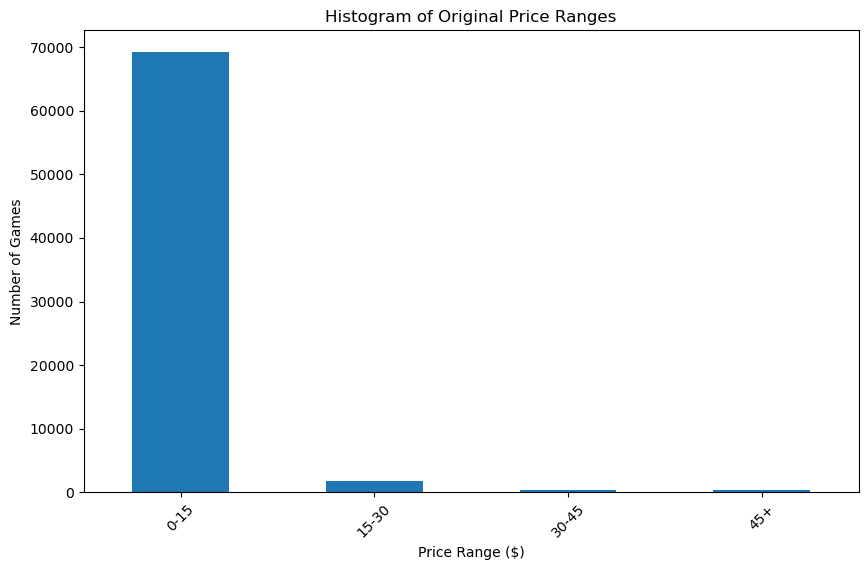

In [25]:
df['Price Range'] = pd.cut(df['Original Price'],
                           bins=[0, 15, 30, 45, float('inf')],
                           right=False, 
                           labels=['0-15', '15-30', '30-45', '45+'])
plt.figure(figsize=(10, 6))
df['Price Range'].value_counts().sort_index().plot(kind='bar')
plt.title('Histogram of Original Price Ranges')
plt.xlabel('Price Range ($)')
plt.ylabel('Number of Games')
plt.xticks(rotation=45)
plt.show()

From the heatmap we can see there was no significant relations between language supported and positive review. The strong positive correlation of 1.00 between these two variables implies that games with higher original prices also tend to have higher discounted prices, which is what we were expected.

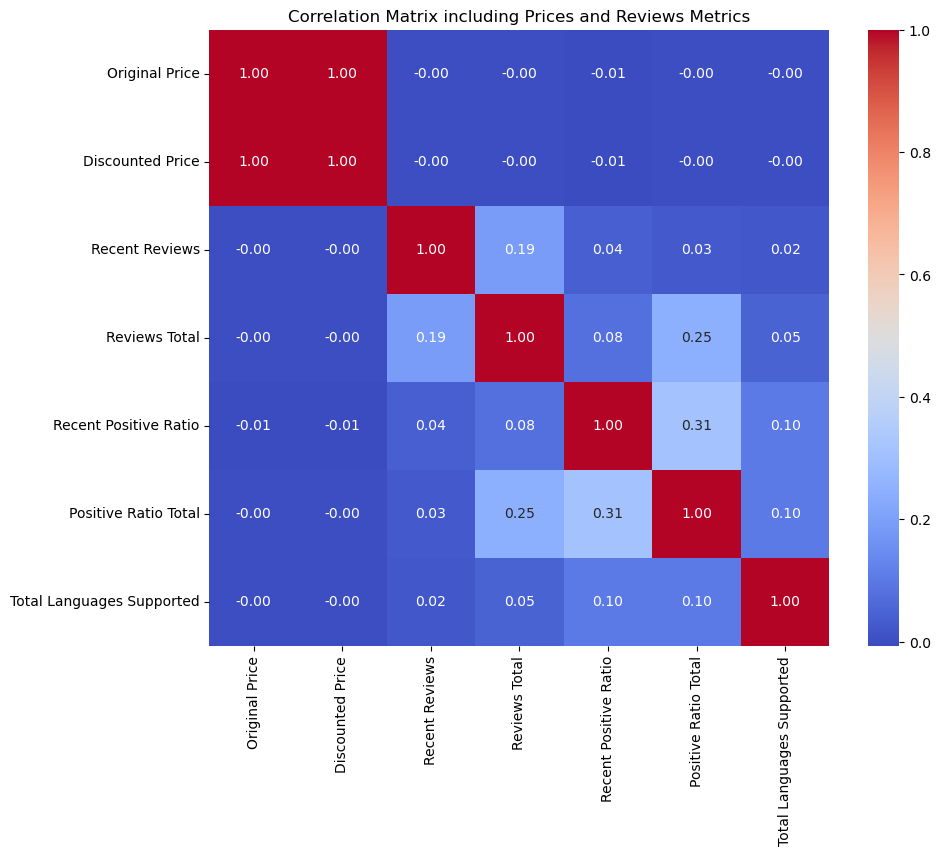

In [26]:
df['Total Languages Supported'] = df['OneHot Encoded Languages'].apply(lambda x: sum(x))

variables_for_correlation = [
    'Original Price', 'Discounted Price', 'Recent Reviews',
    'Reviews Total', 'Recent Positive Ratio', 'Positive Ratio Total',
    'Total Languages Supported'
]

correlation_matrix = df[variables_for_correlation].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix including Prices and Reviews Metrics')
plt.show()

# PCA

Drop irrelevant columns and standardize 

In [70]:
from sklearn.preprocessing import StandardScaler

# Drop non-numeric and identifier columns
X_PCA = df.drop(['Discounted Price','Release Date', 'OneHot Encoded Languages', 'OneHot Encoded Tags', 'OneHot Encoded Features'], axis=1)
X_PCA.set_index('GameID')

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_PCA)

Apply PCA

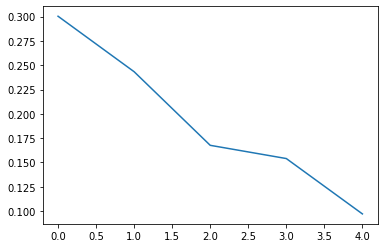

In [88]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
        
# Try reduce to 2 dimensions
pca = PCA(n_components=5)
plt.plot(pca.explained_variance_ratio_)

take up to PC 4 to get to 0.9% variance explained


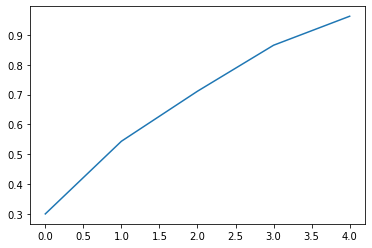

In [89]:
# Select PCs using elbow methods
var_exp_thresh = 0.9
total_var_exp = np.cumsum(pca.explained_variance_ratio_)
plt.plot(total_var_exp);
pcindex = np.where(total_var_exp>=var_exp_thresh)[0]
print(f'take up to PC {pcindex[0]} to get to {var_exp_thresh}% variance explained')

In [90]:
pca = PCA(n_components=4)
pca_X = pca.fit_transform(X_scaled)

# UMAP

In [91]:
import umap

Process onehot columns

In [98]:
one_hot_languages = pd.DataFrame(df['OneHot Encoded Languages'].tolist(), index=df.index)
one_hot_languages.columns = ['Language_' + str(i) for i in range(one_hot_languages.shape[1])]

one_hot_tags = pd.DataFrame(df['OneHot Encoded Tags'].tolist(), index=df.index)
one_hot_tags.columns = ['Tag_' + str(i) for i in range(one_hot_tags.shape[1])]

one_hot_fea = pd.DataFrame(df['OneHot Encoded Features'].tolist(), index=df.index)
one_hot_fea.columns = ['Feature_' + str(i) for i in range(one_hot_fea.shape[1])]

In [101]:
# Drop irrelevant columns
X_UMAP = df.drop(['GameID','Release Date','Discounted Price','OneHot Encoded Languages','OneHot Encoded Tags','OneHot Encoded Features'], axis = 1)
# Add the processed onehot columns
X_UMAP = pd.concat([X_UMAP, one_hot_languages, one_hot_tags, one_hot_fea], axis = 1)
X_UMAP

In [103]:
#Standardize X_UMAP
scaler = StandardScaler()
X_UMAP_scaled = scaler.fit_transform(X_UMAP)

array([[ 1.71641709, 57.57967556,  0.8767957 , ..., -0.12537822,
        -0.13500628, -0.11500006],
       [ 0.39194179, 33.59911289,  0.3967708 , ..., -0.12537822,
        -0.13500628,  8.69564752],
       [-0.93165053,  8.23784303, -1.24902885, ..., -0.12537822,
        -0.13500628, -0.11500006],
       ...,
       [-0.93165053, -0.07278878, -1.86620372, ..., -0.12537822,
        -0.13500628, -0.11500006],
       [ 5.24835123,  0.60526503, -4.88350308, ..., -0.12537822,
        -0.13500628, -0.11500006],
       [-0.93165053, -0.07278878,  1.15109564, ..., -0.12537822,
        -0.13500628, -0.11500006]])

Apply UMAP

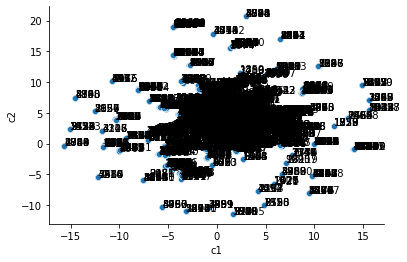

In [109]:
# Attempt to visualize UMAP
umap_5 = umap.UMAP(n_neighbors=5, min_dist=0.1, metric='euclidean')
ucs = umap_5.fit_transform(X_UMAP_scaled)

ucs = pd.DataFrame(ucs,columns=['c1','c2'])
ucs.index = X_UMAP.index
plot_components(ucs,'c1','c2')

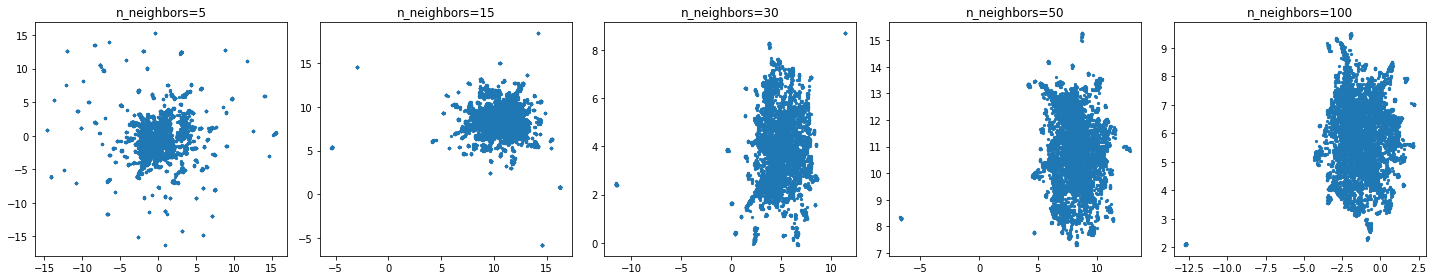

In [110]:
# List of parameters to try
values_of_n_neighbors = [5,10,15,20,30]
fig, axs = plt.subplots(1, len(values_of_n_neighbors), figsize=(20, 4))

# Plot UMAP plots to visualize local and global structures
for i, n in enumerate(values_of_n_neighbors):
    reducer = umap.UMAP(n_neighbors=n, n_components=2, random_state=99)
    embedding = reducer.fit_transform(X_UMAP_scaled)
    axs[i].scatter(embedding[:, 0], embedding[:, 1], s=5)
    axs[i].set_title(f'n_neighbors={n}')
plt.tight_layout()

# Proposed Solution

To address the challenge of predicting discount prices for Steam games and effectively clustering them based on tags and features, we propose a multi-faceted solution leveraging DBSCAN, Spectral Clustering, and Gaussian Mixture Models(GMM).

#### DBSCAN (Density-Based Spatial Clustering of Applications with Noise):
DBSCAN is chosen for its ability to identify clusters of varying shapes and sizes without the need for specifying the number of clusters a priori. This characteristic is particularly advantageous given the diverse and potentially irregular groupings of games based on tags. DBSCAN works by grouping closely packed points and identifying points in low-density areas as outliers. This method is expected to effectively segregate games into meaningful clusters based on similarity in tags and features, which are pivotal for predicting discount prices.

#### Spectral Clustering:
Spectral Clustering is selected for its effectiveness in identifying complex structures within data. It works by using the eigenvalues of a similarity matrix to perform dimensionality reduction before clustering in lower dimensions. This approach is particularly suited for our dataset since it can capture the intricate relationships between games based on their tags and features, which might not be linearly separable.

#### Gaussian Mixture Models (GMM):
GMM is a probabilistic model that assumes all data points are generated from a mixture of a finite number of Gaussian distributions with unknown parameters. It offers flexibility in the shape of clusters, making it suitable for our dataset where games may naturally group into clusters with varying sizes and elliptical shapes. GMM's soft-clustering approach, where each point is assigned a probability of belonging to each cluster, provides a nuanced understanding of game groupings.

#### Implementation:
The implementation will utilize the scikit-learn library in Python:<br>
DBSCAN (sklearn.cluster.DBSCAN): DBSCAN(eps=n, min_samples=n), adjusting eps and min_samples based on the dataset's density.<br>
Spectral Clustering (sklearn.cluster.SpectralClustering): SpectralClustering(n_clusters=n), determining n_clusters after EDA and preliminary clustering attempts.<br>
Gaussian Mixture Models (sklearn.mixture.GaussianMixture): GaussianMixture(n_components=n, covariance_type='full'), with n_components decided based on model performance and BIC (Bayesian Information Criterion) scores.<br>

#### Model Evaluation:
Clustering performance will be evaluated using the Adjusted Rand Index (ARI), and the predictive model's accuracy for discount prices will be assessed using Mean Absolute Error (MAE).<br>

# Evaluation Metrics

**Prediction Accuracy**: Mean Absolute Error (MAE)

It measures the average magnitude of errors in a set of predictions, without considering their direction. It's calculated as the average of the absolute differences between predicted values and actual values, making it a straightforward and interpretable metric for assessing price prediction accuracy

**Clustering Performance**: Adjusted Ranked Index (ARI)

The Adjusted Rand Index (ARI) measures the similarity between two clusterings, considering all pairs of samples and counting pairs that are assigned in the same or different clusters in the predicted and true clusterings. The ARI is adjusted for the chance grouping of elements, making it a more reliable metric for the quality of the clustering.

MAE will give us a direct measure of the accuracy of the price predictions, while ARI will assess the effectiveness of our clustering, ensuring that the foundation for our predictions—how games are grouped based on tags and features—is sound. This dual approach allows us to optimize both the clustering of games and the accuracy of the price predictions.

# Results

You may have done tons of work on this. Not all of it belongs here. 

Reports should have a __narrative__. Once you've looked through all your results over the quarter, decide on one main point and 2-4 secondary points you want us to understand. Include the detailed code and analysis results of those points only; you should spend more time/code/plots on your main point than the others.

If you went down any blind alleys that you later decided to not pursue, please don't abuse the TAs time by throwing in 81 lines of code and 4 plots related to something you actually abandoned.  Consider deleting things that are not important to your narrative.  If its slightly relevant to the narrative or you just want us to know you tried something, you could keep it in by summarizing the result in this report in a sentence or two, moving the actual analysis to another file in your repo, and providing us a link to that file.

### Subsection 1

You will likely have different subsections as you go through your report. For instance you might start with an analysis of the dataset/problem and from there you might be able to draw out the kinds of algorithms that are / aren't appropriate to tackle the solution.  Or something else completely if this isn't the way your project works.

### Subsection 2

Another likely section is if you are doing any feature selection through cross-validation or hand-design/validation of features/transformations of the data

### Subsection 3

Probably you need to describe the base model and demonstrate its performance.  Maybe you include a learning curve to show whether you have enough data to do train/validate/test split or have to go to k-folds or LOOCV or ???

### Subsection 4

Perhaps some exploration of the model selection (hyper-parameters) or algorithm selection task. Validation curves, plots showing the variability of perfromance across folds of the cross-validation, etc. If you're doing one, the outcome of the null hypothesis test or parsimony principle check to show how you are selecting the best model.

### Subsection 5 

Maybe you do model selection again, but using a different kind of metric than before?



# Discussion

### Interpreting the result

OK, you've given us quite a bit of tech informaiton above, now its time to tell us what to pay attention to in all that.  Think clearly about your results, decide on one main point and 2-4 secondary points you want us to understand. Highlight HOW your results support those points.  You probably want 2-5 sentences per point.

### Limitations

Are there any problems with the work?  For instance would more data change the nature of the problem? Would it be good to explore more hyperparams than you had time for?   

### Ethics & Privacy

This project leverages publicly available datasets from platforms such as Kaggle, with the intent of adhering strictly to academic research protocols and respecting all relevant data usage agreements. We take measures to address potential inaccuracies within our dataset by cross-referencing information with alternative, independent sources. We mainly focuses on public data provided by Steam, hence, we acknowledge that the insights may not be universally applicable to other gaming platform.

### Conclusion

Reiterate your main point and in just a few sentences tell us how your results support it. Mention how this work would fit in the background/context of other work in this field if you can. Suggest directions for future work if you want to.

# Footnotes
<a name="lorenznote"></a>1.[^](#lorenz): Lorenz, T. (9 Dec 2021) Birds Aren’t Real, or Are They? Inside a Gen Z Conspiracy Theory. *The New York Times*. https://www.nytimes.com/2021/12/09/technology/birds-arent-real-gen-z-misinformation.html<br> 
<a name="admonishnote"></a>2.[^](#admonish): Also refs should be important to the background, not some randomly chosen vaguely related stuff. Include a web link if possible in refs as above.<br>
<a name="sotanote"></a>3.[^](#sota): Perhaps the current state of the art solution such as you see on [Papers with code](https://paperswithcode.com/sota). Or maybe not SOTA, but rather a standard textbook/Kaggle solution to this kind of problem
